<a href="https://colab.research.google.com/github/sanchukanirupama/LSTM-Fake-News-Classifier/blob/main/Fake_news_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Modules and loading data**

In [38]:
import nltk
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORD
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

In [64]:
# load the dataset
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

In [65]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [66]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


**Data Preporcessing**

In [67]:
df_true['is_fake'] = 0
df_fake['is_fake'] = 1
df_final = pd.concat([df_true, df_fake]).reset_index(drop = True)
df_final

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


In [68]:
df_final.drop(columns = ['date'], inplace = True)

In [69]:
df_final['news'] = df_final['title'] + ' ' + df_final['text']

In [70]:
df_final

,title,text,subject,is_fake,news
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,Trump wants Postal Service to charge 'much mor...
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,1,McPain: John McCain Furious That Iran Treated ...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,1,How to Blow $700 Million: Al Jazeera America F...


In [71]:
df_final['news'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

**Understanding the Data**

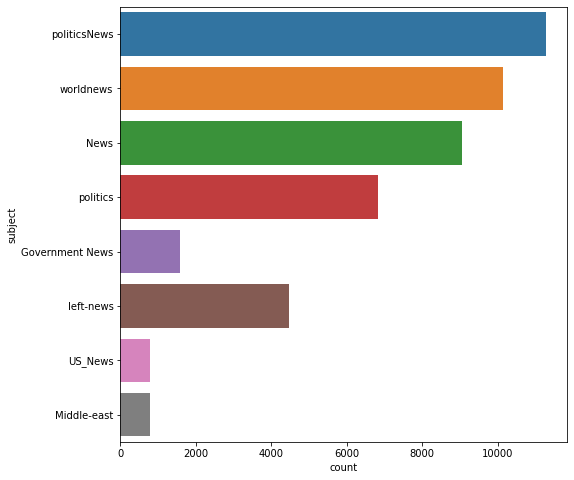

In [72]:
plt.figure(figsize=(8,8))
sns.countplot(y='subject', data = df_final )

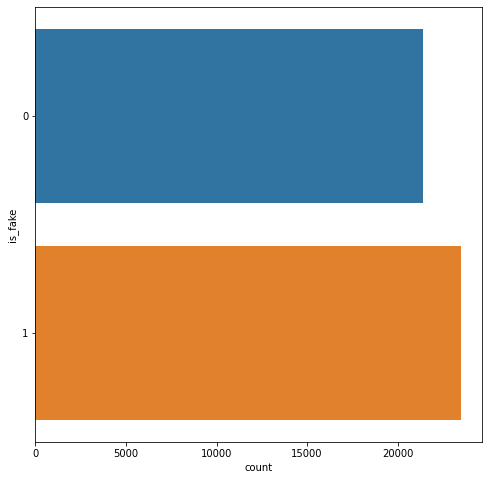

In [73]:
plt.figure(figsize=(8,8))
sns.countplot(y='is_fake', data = df_final )

**Data Cleaning**

In [74]:
df_final.drop(columns = ['title', 'text'], inplace = True)

In [75]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
#defining stopwords
stop_words = stopwords.words('english')
stop_words.extend(['use', 're', 'edu', 'from', 'also'])

In [77]:
#function which stop words and the words less than 2 characters
def remove_stop_words (text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
      result.append(token)

  return result

In [78]:
#remove stopwords from news column
df_final['clean_news'] = df_final['news'].apply(remove_stop_words)

In [79]:
print(df_final['clean_news'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [80]:
#creating a list of words
list_of_words = []
for i in df_final.clean_news:
  for j in i:
    list_of_words.append(j)

In [81]:
#Total unique words
#finding the number of unique_words is needed to building the LSTM model
unique_words = len(list(set(list_of_words)))
unique_words

108706

In [82]:
#turn list of words to a string
df_final['clean_news_joined'] = df_final['clean_news'].apply(lambda x: " ".join(x))
df_final.drop(columns = ['clean_news', 'news'], inplace = True)

In [83]:
df_final

,subject,is_fake,clean_news_joined
0,politicsNews,0,budget fight looms republicans flip fiscal scr...
1,politicsNews,0,military accept transgender recruits monday pe...
2,politicsNews,0,senior republican senator mueller washington r...
3,politicsNews,0,russia probe helped australian diplomat washin...
4,politicsNews,0,trump wants postal service charge amazon shipm...
...,...,...,...
44893,Middle-east,1,mcpain john mccain furious iran treated sailor...
44894,Middle-east,1,justice yahoo settles mail privacy class actio...
44895,Middle-east,1,sunnistan allied safe zone plan territorial bo...
44896,Middle-east,1,blow million jazeera america finally calls qui...


In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Data Preparing**

In [84]:
# length of maximum news
#finding the maximum number of words in a news is needed when we padding the tokenized data
maxlen = -1
for doc in df_final.clean_news_joined:
  tokens = nltk.word_tokenize(doc)
  if (maxlen < len(tokens)):
    maxlen = len(tokens)
print("The maximum number of words in a news is ", maxlen)

The maximum number of words in a news is  4406


In [85]:
#splitting the Data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_final.clean_news_joined, df_final.is_fake, test_size = 0.2)

In [86]:
from nltk import word_tokenize

In [87]:
#word tokernizing
tokenizer = Tokenizer(num_words = unique_words )
tokenizer.fit_on_texts(x_train)
train_sequence = tokenizer.texts_to_sequences(x_train)
test_sequence = tokenizer.texts_to_sequences(x_test)

In [89]:
#Add padding
pad_train = pad_sequences(train_sequence, maxlen = 4406, padding = 'post', truncating = 'post' )
pad_test = pad_sequences(test_sequence, maxlen = 4406, padding = 'post')

**Building the LSTM Model**

In [94]:
def LSTM_modle():
  model = Sequential()
  model.add(Embedding(unique_words, output_dim = 256)),
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])
  
  return model

In [95]:
model = LSTM_modle()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 256)         27828736  
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28,264,193
Trainable params: 28,264,193
Non-trainable params: 0
__________________________________________

In [96]:
y_train = np.asarray(y_train)

In [97]:
#model training
model.fit(pad_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 249s 487ms/step - loss: 0.0458 - acc: 0.9846 - val_loss: 0.0075 - val_acc: 0.9989
Epoch 2/2
506/506 [==============================] - 235s 464ms/step - loss: 9.8399e-04 - acc: 0.9998 - val_loss: 0.0070 - val_acc: 0.9986


**Predicting the Results check the accuracy**

In [98]:
#prediction
predicted_result = model.predict(pad_test)

In [100]:
#if predicted value > 0.5 its real else fake
prediction = []
for i in range (len(predicted_result)):
  if predicted_result[i].item() > 0.5:
    prediction.append(1)
  else:
    prediction.append(0)


In [101]:
#accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(list(y_test), prediction)

print(accuracy)


0.9979955456570155


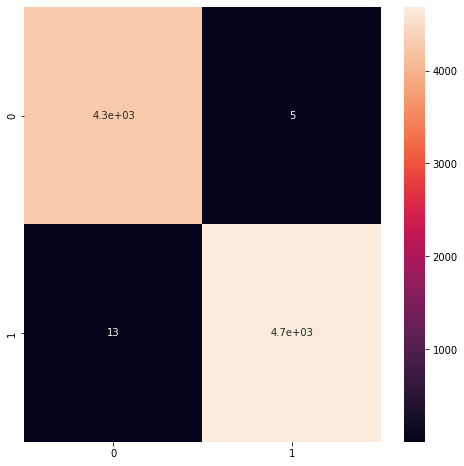

In [102]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True)
